In [1]:
from numpy import array, sqrt, sin, cos, arctan2, eye, hstack, zeros, ones, trace, delete, set_printoptions
from numpy.linalg import inv, norm, eigh
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from lib.geodesy import ECEF2geod
from lib.convert import rad2deg

# Representation of float numbers in arrays when printed
set_printoptions(formatter={'float_kind':"{:.3f}".format})


# Constants
c = 2.99792458e8             # Speed of light [meter/second]

# WGS84 parameters
a = 6378137                  # Semi-major axis [meter]
f = 1/298.257223563          # Flattening
b = a*(1 - f)                # Semi-minor axis [meter]


# Statistic tables @ 5%
t_tab = [12.706, 4.303, 3.182, 2.776, 2.571, 2.446, 2.364]


# Estimate error
def est_error(H, W, z):
    
    # Initialize vectors
    nabla = []; sigma = []; t = []
    
    # System size
    n, e = H.shape
    
    # Estimating outliers
    for i in range(0, n):
        ei = zeros([n, 1]); ei[i] = 1; Hi = hstack([H, ei])
        xi = inv(Hi.T@W@Hi)@Hi.T@W@z; vi = Hi@xi - z
        Qxi = inv(Hi.T@W@Hi); qi = Qxi[e, e]
        nabla.append(xi[e, 0])
        sigma.append(sqrt(1/(n - e - 1)*(vi.T@W@vi)*qi)[0, 0])
        t.append(abs(nabla[i]/sigma[i]))
        
    return nabla, sigma, t


# Error ellipse2D
def error_ellipse2D(xc, yc, cov, sigma=1, **kwargs):
    eigval, eigvec = eigh(cov)        # Assume symmetric matrix
    order = eigval.argsort()[::-1]    # Sort in decending order
    eigval, eigvec = eigval[order], eigvec[:, order]
    theta = rad2deg(arctan2(*eigvec[:, 0][::-1]))
    
    return Ellipse(xy=(xc, yc),
                   width=2*sigma*sqrt(eigval[0]),
                   height=2*sigma*sqrt(eigval[1]),
                   angle=theta, **kwargs)


# Satellite coordinates adjusted for earth rotation [meter]
Xs = array([[ 16326752.151,  13183092.336, 16097827.926],
            [ 14050839.890, -21036999.898,  8241951.622],
            [  7562364.857,  17272086.865, 19245152.658],
            [  4088490.405, -22201485.306, 14035741.754],
            [ 18183513.847,   1674550.344, 19513032.152],
            [ 14926470.369, -11434281.485, 19161782.900],
            [ 13362799.875,  21908402.066,  7021690.383],
            [ -3196562.499,  14840389.672, 21491981.175],
            [-10952621.217, -10431043.213, 21740756.738]])


# Approximate receiver position [meter]
x0 = array([[3172302],
            [603839],
            [5481967],
            [0]])


# Standard deviation of unit weight [meter]
sigma0 = 1


# Standard deviation of observation [meter]
sigmaz = 1


# Observed pseudoranges [meter]
R = array([[21070672],
           [24377980],
           [22057378],
           [24373944],
           [20575650],
           [21684412],
           [23666456],
           [22350884],
           [24199797]])


# Covariance matrix of the observations [meter]
SIGMAz = sigmaz**2*eye(len(R))


# Preliminary ranges [meter]
R0 = norm(Xs - x0[0:3].T, axis=1).reshape(len(R), 1)


# Observation vector
z = R - R0


# Design matrix
H = hstack([-(Xs - x0[0:3].T)/R0, ones([len(R), 1])])


# System size
n, e = H.shape


# Compute weights
W = sigma0**2*inv(SIGMAz)

In [2]:
# Estimate errors
nabla, sigma, t = est_error(H, W, z)


# Outlier detection
if max(t) > t_tab[n - e - 1]:
        
    # Outlier identification
    ind = t.index(max(t))
        
    # Removing outlier from system (adaption)
    H = delete(H, ind, 0); z = delete(z, ind, 0)
    W = delete(W, ind, 0); W = delete(W, ind, 1)
    
    # System size
    n, e = H.shape
    
    # Estimate errors in new system
    nabla, sigma, t = est_error(H, W, z)
    

# Inner reliability
nablamax = []
for i in range(0, n):
    nablamax.append(max([abs(nabla[i] + t_tab[n - e - 1]*sigma[i]), abs(nabla[i] - t_tab[n - e - 1]*sigma[i])]))

print("Minimal Detectable Bias: {:.3f} m".format(max(nablamax)))


# Outer reliability
nablax = []
for i in range(0, n):
    nabla = zeros([n, 1]); nabla[i] = nablamax[i]
    dx = inv(H.T@W@H)@H.T@W@nabla
    nablax.append(norm(dx[0:3]))

print("Minimal Detectable Error: {:.3f} m".format(max(nablax)))

Minimal Detectable Bias: 4.464 m
Minimal Detectable Error: 5.140 m


In [3]:
# LSQ solution
dx = inv(H.T@W@H)@H.T@W@z
x = x0 + dx

print("Receiver position (ECEF): {:.3f} m, {:.3f} m, {:.3f} m".format(*x[0], *x[1], *x[2]))

# Geodetic coordinates
lat, lon, h = ECEF2geod(a, b, x[0:3])
print("Receiver position (Geodetic): {:.8f} deg, {:.8f} deg, {:.3f} m".format(rad2deg(lat), rad2deg(lon), h))
print("Receiver clock error: {:.3f} m".format(*x[3]))

Receiver position (ECEF): 3172308.873 m, 603841.051 m, 5481979.663 m
Receiver position (Geodetic): 59.66697866 deg, 10.77718222 deg, 169.926 m
Receiver clock error: 0.307 m


In [4]:
# Compute residuals
v = H@dx - z
print(v)

[[-0.722]
 [-0.300]
 [0.685]
 [0.279]
 [0.295]
 [0.231]
 [-0.319]
 [-0.150]]


In [5]:
# Standard deviation of unit weight
sigma0_hat = sqrt((v.T@W@v)/(n - e))
print("Std. dev. of unit weight: {:.3f} m".format(sigma0_hat[0, 0]))

Std. dev. of unit weight: 0.597 m


In [6]:
# Cofactor matrix (ECEF)
Qx = inv(H.T@W@H)
print(Qx)

[[1.062 -0.099 0.904 0.602]
 [-0.099 0.244 -0.175 -0.096]
 [0.904 -0.175 2.994 1.534]
 [0.602 -0.096 1.534 0.935]]


In [7]:
# Covariance matrix (ECEF)
SIGMAx = sigma0_hat**2*Qx
print(SIGMAx)

[[0.378 -0.035 0.322 0.214]
 [-0.035 0.087 -0.062 -0.034]
 [0.322 -0.062 1.066 0.546]
 [0.214 -0.034 0.546 0.333]]


In [8]:
# Rotate from e-frame to g-frame (ned)
Ce_g = array([[-sin(lat)*cos(lon), -sin(lat)*sin(lon), cos(lat), 0],
              [-sin(lon), cos(lon), 0, 0],
              [-cos(lat)*cos(lon), -cos(lat)*sin(lon), -sin(lat), 0],
              [0, 0, 0, 1]])

# Cofactor matrix (topocentric)
Qx_g = Ce_g@Qx@Ce_g.T
print(Qx_g)

[[0.761 0.037 -0.451 0.280]
 [0.037 0.309 0.417 -0.207]
 [-0.451 0.417 3.230 -1.614]
 [0.280 -0.207 -1.614 0.935]]


In [9]:
# Covariance matrix (topocentric)
SIGMAx_g = sigma0_hat**2*Qx_g;
print(SIGMAx_g)

[[0.271 0.013 -0.161 0.100]
 [0.013 0.110 0.148 -0.074]
 [-0.161 0.148 1.150 -0.574]
 [0.100 -0.074 -0.574 0.333]]


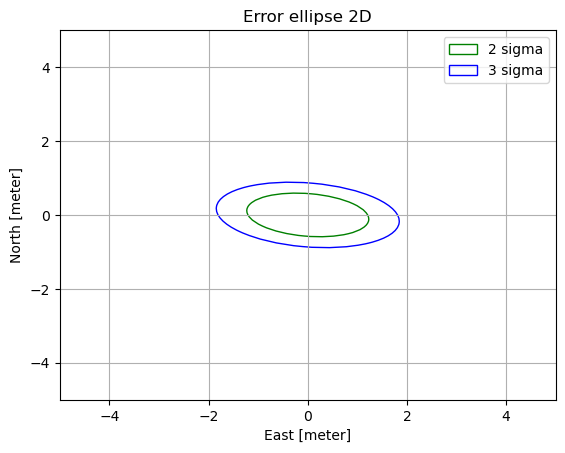

In [10]:
# Plot error ellipse
fig, ax = plt.subplots()

ell1 = error_ellipse2D(0, 0, SIGMAx[0:2, 0:2], sigma=2, ec='green', label='2 sigma')
ell2 = error_ellipse2D(0, 0, SIGMAx[0:2, 0:2], sigma=3, ec='blue', label='3 sigma')

ell1.set_facecolor('none')
ax.add_patch(ell1)

ell2.set_facecolor('none')
ax.add_patch(ell2)

plt.title("Error ellipse 2D")
plt.xlabel("East [meter]")
plt.ylabel("North [meter]")
plt.legend()
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.grid()

plt.show()

In [11]:
# Geometric dilution of precision (GDOP)
GDOP = sqrt(trace(Qx_g))
print("GDOP: {:6.2f}".format(GDOP))

# Position dilution of precision (PDOP)
PDOP = sqrt(trace(Qx_g[0:3, 0:3]))
print("PDOP: {:6.2f}".format(PDOP))

# Horizontal dilution of precision (HDOP)
HDOP = sqrt(trace(Qx_g[0:2, 0:2]))
print("HDOP: {:6.2f}".format(HDOP))

# Vertical dilution of precision (VDOP)
VDOP = sqrt(Qx_g[2, 2])
print("VDOP: {:6.2f}".format(VDOP))

# Time dilution of precision (TDOP)
TDOP = sqrt(Qx_g[3, 3])
print("TDOP: {:6.2f}".format(TDOP))

# Distance Root Mean Squared (DRMS)
DRMS = sqrt(trace(SIGMAx[0:2, 0:2]))
print("DRMS: {:6.2f} m".format(DRMS))

# Circular Error Probable (CEP)
CEP = 0.75*DRMS
print("CEP : {:6.2f} m".format(CEP))

GDOP:   2.29
PDOP:   2.07
HDOP:   1.03
VDOP:   1.80
TDOP:   0.97
DRMS:   0.68 m
CEP :   0.51 m
